In [1]:
import torch # 파이토치 
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import pandas as pd

# 데이터 경로
data_path = "D:Dataset/dataset/Aerial_Cactus_Identification/"

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [5]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(labels, 
                                test_size=0.1,
                                stratify=labels['has_cactus'],
                                random_state=50)

In [6]:
import cv2 # OpenCV 라이브러리
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir="train/", transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드 
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    # 이미지 ID # iloc[행:열] 숫자
        img_path = data_path + self.img_dir + img_id # 이미지 파일 경로 
        image = cv2.imread(img_path)     # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

In [7]:
from torchvision import transforms # 이미지 변환을 위한 모듈

# augmentation 증강

# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode='symmetric'),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

# 검증 및 테스트 데이터용 변환기
transform_test= transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(32, padding_mode='symmetric'),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

In [8]:
dataset_train = ImageDataset(df=train, img_dir='train/', transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir='train/', transform=transform_test)

In [9]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

In [10]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        # 1 ~ 5번째 {합성곱, 배치 정규화, 최대 풀링} 계층 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32), # 배치 정규화
                                    nn.LeakyReLU(), # LeakyReLU 활성화 함수
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=4) 
        # 전결합 계층
        self.fc1 = nn.Linear(in_features=512 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)

    # 순전파 출력 정의 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1) # 평탄화
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [11]:
model = Model().to(device)
model

Model(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128,

In [12]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

In [15]:
# 옵티마이저
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)

In [16]:
epochs = 70 # 총 에폭

# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

에폭 [1/70] - 손실값: 0.1305
에폭 [2/70] - 손실값: 0.0704
에폭 [3/70] - 손실값: 0.0515
에폭 [4/70] - 손실값: 0.0421
에폭 [5/70] - 손실값: 0.0400
에폭 [6/70] - 손실값: 0.0354
에폭 [7/70] - 손실값: 0.0293
에폭 [8/70] - 손실값: 0.0296
에폭 [9/70] - 손실값: 0.0259
에폭 [10/70] - 손실값: 0.0242
에폭 [11/70] - 손실값: 0.0232
에폭 [12/70] - 손실값: 0.0226
에폭 [13/70] - 손실값: 0.0222
에폭 [14/70] - 손실값: 0.0214
에폭 [15/70] - 손실값: 0.0202
에폭 [16/70] - 손실값: 0.0210
에폭 [17/70] - 손실값: 0.0176
에폭 [18/70] - 손실값: 0.0183
에폭 [19/70] - 손실값: 0.0170
에폭 [20/70] - 손실값: 0.0156
에폭 [21/70] - 손실값: 0.0158
에폭 [22/70] - 손실값: 0.0148
에폭 [23/70] - 손실값: 0.0132
에폭 [24/70] - 손실값: 0.0139
에폭 [25/70] - 손실값: 0.0133
에폭 [26/70] - 손실값: 0.0105
에폭 [27/70] - 손실값: 0.0137
에폭 [28/70] - 손실값: 0.0114
에폭 [29/70] - 손실값: 0.0085
에폭 [30/70] - 손실값: 0.0094
에폭 [31/70] - 손실값: 0.0104
에폭 [32/70] - 손실값: 0.0089
에폭 [33/70] - 손실값: 0.0088
에폭 [34/70] - 손실값: 0.0090
에폭 [35/70] - 손실값: 0.0108


KeyboardInterrupt: 

In [17]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수 임포트

# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

In [18]:
model.eval() # 모델을 평가 상태로 설정 

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device) 
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률  
        true = labels.cpu() # 실제값 
        # 예측 확률과 실제값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)
        
# 검증 데이터 ROC AUC 점수 계산
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}') #0.9999

검증 데이터 ROC AUC : 0.9993


In [20]:
dataset_test = ImageDataset(df=submission, img_dir='test/', transform=transform_test)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

In [21]:
model.eval() # 모델을 평가 상태로 설정

preds = [] # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

In [22]:
submission['has_cactus'] = preds

# 애매한 그림 TOP11

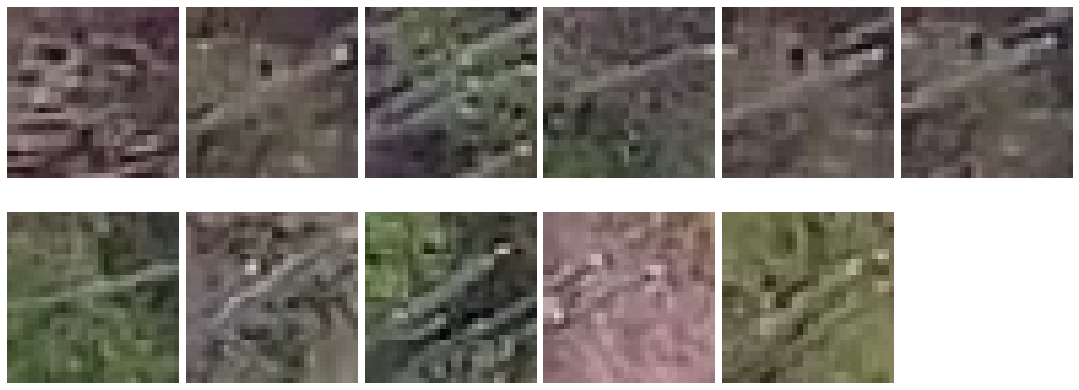

In [55]:
imgs = submission[(submission["has_cactus"]>0.45)&(submission["has_cactus"]<0.55)].id.values

import matplotlib.gridspec as gridspec # 여러개의 그림 그리기
grid = gridspec.GridSpec(2, 6) # 서브플롯 배치(2행 6열로 출력) # 도화지
plt.rc('font', size=7) # 폰트사이즈 조절
plt.figure(figsize=(15, 6))    # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 서브플롯 배치(2행 6열로 출력) # 도화지
for idx, img in enumerate(imgs):
    sample_img = cv2.imread(data_path+"test/"+img)
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx]) 
    ax.imshow(sample_img)                               # 이미지 출력 
    ax.axis("off")  
plt.tight_layout()